# **Homework 8 - Anomaly Detection**

If there are any questions, please contact mlta-2023-spring@googlegroups.com

Slide:    [Link](https://docs.google.com/presentation/d/18LkR8qulwSbi3SVoLl1XNNGjQQ_qczs_35lrJWOmHCk/edit?usp=sharing)　Kaggle: [Link](https://www.kaggle.com/t/c76950cc460140eba30a576ca7668d28)

# Set up the environment


## Package installation

In [15]:
# Training progress bar
!pip install -q qqdm

## Downloading data

In [2]:
!git clone https://github.com/chiyuanhsiao/ml2023spring-hw8

fatal: destination path 'ml2023spring-hw8' already exists and is not an empty directory.


# Import packages

In [61]:
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from torch.optim import Adam, AdamW
from qqdm import qqdm, format_str
import pandas as pd

# Loading data

In [62]:

train = np.load('ml2023spring-hw8-download/trainingset.npy', allow_pickle=True)
test = np.load('ml2023spring-hw8-download/testingset.npy', allow_pickle=True)

print(train.shape)
print(test.shape)

(100000, 64, 64, 3)
(19636, 64, 64, 3)


## Random seed
Set the random seed to a certain value for reproducibility.

In [63]:
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(14515123)

# Autoencoder

# Models & loss

In [69]:
class fcn_autoencoder(nn.Module):
    def __init__(self):
        super(fcn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # nn.Linear(64 * 64 * 3, 128),
            # nn.ReLU(),
            # nn.Linear(128, 64),
            # nn.ReLU(), 
            # nn.Linear(64, 12), 
            # nn.ReLU(), 
            # nn.Linear(12, 3)
            
            nn.Linear(64 * 21 * 3, 1000),
            nn.ReLU(), 
            nn.Linear(1000, 500),
            nn.ReLU(), nn.ReLU(), 
            nn.Linear(500, 250),
            nn.ReLU(), 
            nn.Linear(250, 125),
            nn.ReLU(), 
            nn.Linear(125, 80),
            nn.ReLU(), 
        )    # Hint: dimension of latent space can be adjusted
        
        self.decoder = nn.Sequential(
            # nn.Linear(3, 12),
            # nn.ReLU(), 
            # nn.Linear(12, 64),
            # nn.ReLU(),
            # nn.Linear(64, 128),
            # nn.ReLU(), 
            # nn.Linear(128, 64 * 64 * 3), 
            # nn.Tanh()
            
            nn.Linear(80, 125),
            nn.ReLU(), 
            nn.Linear(125, 250),
            nn.ReLU(), 
            nn.Linear(250, 500),
            nn.ReLU(), 
            nn.Linear(500, 1000),
            nn.ReLU(),
            nn.Linear(1000, 64 * 21 * 3), 
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, 4, stride=2, padding=1),#nn.Conv2d(3, 12, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),        
            nn.BatchNorm2d(256),
            nn.ReLU(),
			nn.Conv2d(256, 512, 4, stride=2, padding=1),     
            nn.BatchNorm2d(512),    
            nn.ReLU(),
        )   # Hint:  dimension of latent space can be adjusted
        self.decoder = nn.Sequential(
			nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),#nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
			nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), #nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1), #nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),    
            nn.ReLU(),
        )
        self.enc_out_1 = nn.Sequential(
            nn.Conv2d(24, 48, 4, stride=2, padding=1),  
            nn.ReLU(),
        )
        self.enc_out_2 = nn.Sequential(
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        # Hint: can add more layers to encoder and decoder
        self.decoder = nn.Sequential(
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), 
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), 
            nn.Tanh(),
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return self.enc_out_1(h1), self.enc_out_2(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_vae(recon_x, x, mu, logvar, criterion):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return mse + KLD


class Resnet(nn.Module):
    def __init__(self, fc_hidden1=1024, fc_hidden2=768, drop_p=0.3, CNN_embed_dim=256):
        super(Resnet, self).__init__()

        self.fc_hidden1, self.fc_hidden2, self.CNN_embed_dim = fc_hidden1, fc_hidden2, CNN_embed_dim

        # CNN architechtures
        self.ch1, self.ch2, self.ch3, self.ch4 = 16, 32, 64, 128
        self.k1, self.k2, self.k3, self.k4 = (5, 5), (3, 3), (3, 3), (3, 3)      # 2d kernal size
        self.s1, self.s2, self.s3, self.s4 = (2, 2), (2, 2), (2, 2), (2, 2)      # 2d strides
        self.pd1, self.pd2, self.pd3, self.pd4 = (0, 0), (0, 0), (0, 0), (0, 0)  # 2d padding

        # encoding components
        resnet = models.resnet18(pretrained=False)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.fc1 = nn.Linear(resnet.fc.in_features, self.fc_hidden1)
        self.bn1 = nn.BatchNorm1d(self.fc_hidden1, momentum=0.01)
        self.fc2 = nn.Linear(self.fc_hidden1, self.fc_hidden2)
        self.bn2 = nn.BatchNorm1d(self.fc_hidden2, momentum=0.01)

        self.fc3_mu = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)      # output = CNN embedding latent variables

        # Sampling vector
        self.fc4 = nn.Linear(self.CNN_embed_dim, self.fc_hidden2)
        self.fc_bn4 = nn.BatchNorm1d(self.fc_hidden2)
        self.fc5 = nn.Linear(self.fc_hidden2, 64 * 4 * 4)
        self.fc_bn5 = nn.BatchNorm1d(64 * 4 * 4)
        self.relu = nn.ReLU(inplace=True)

        # Decoder
        self.convTrans6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=self.k4, stride=self.s4,
                               padding=self.pd4),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),
        )
        self.convTrans7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=self.k3, stride=self.s3,
                               padding=self.pd3),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace=True),
        )

        self.convTrans8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=self.k2, stride=self.s2,
                               padding=self.pd2),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()    # y = (y1, y2, y3) \in [0 ,1]^3
        )


    def encode(self, x):
        x = self.resnet(x)  # ResNet
        x = x.view(x.size(0), -1)  # flatten output of conv

        # FC layers
        if x.shape[0] > 1:
            x = self.bn1(self.fc1(x))
        else:
            x = self.fc1(x)
        x = self.relu(x)
        if x.shape[0] > 1:
            x = self.bn2(self.fc2(x))
        else:
            x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3_mu(x)
        return x

    def decode(self, z):
        if z.shape[0] > 1:
            x = self.relu(self.fc_bn4(self.fc4(z)))
            x = self.relu(self.fc_bn5(self.fc5(x))).view(-1, 64, 4, 4)
        else:
            x = self.relu(self.fc4(z))
            x = self.relu(self.fc5(x)).view(-1, 64, 4, 4)
        x = self.convTrans6(x)
        x = self.convTrans7(x)
        x = self.convTrans8(x)
        x = F.interpolate(x, size=(64, 64), mode='bilinear', align_corners=True)
        return x

    def forward(self, x):
        z = self.encode(x)
        x_reconst = self.decode(z)

        return x_reconst

# Dataset module

Module for obtaining and processing data. The transform function here normalizes image's pixels from [0, 255] to [-1.0, 1.0].


In [70]:
class CustomTensorDataset(TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors):
        self.tensors = tensors
        if tensors.shape[-1] == 3:
            self.tensors = tensors.permute(0, 3, 1, 2)
        
        self.transform = transforms.Compose([
          transforms.Lambda(lambda x: transforms.functional.crop(x, top=int(x.shape[2]*1/5), left=0, height=int(x.shape[2]*1/3), width=x.shape[2])),
          transforms.Lambda(lambda x: x.to(torch.float32)),
          transforms.Lambda(lambda x: 2. * x/255. - 1.),
        ])
        self.ori_transform = transforms.Compose([
          transforms.Lambda(lambda x: x.to(torch.float32)),
          transforms.Lambda(lambda x: 2. * x/255. - 1.),
        ])
        
    def __getitem__(self, index):
        x = self.tensors[index]
        
        if self.transform:
            # mapping images to [-1.0, 1.0]
            x = self.transform(x)

        return x
    def __get_ori_item__(self, index):
        x = self.tensors[index]
        if self.ori_transform:
            # mapping images to [-1.0, 1.0]
            x = self.ori_transform(x)
        return x

    def __len__(self):
        return len(self.tensors)

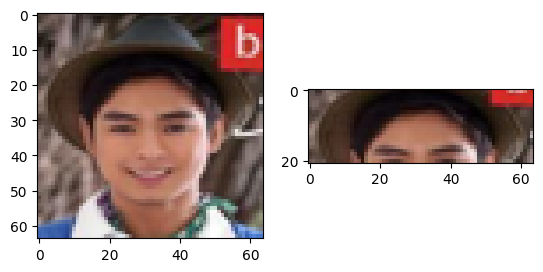

In [98]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

x = torch.from_numpy(train)
train_set = CustomTensorDataset(x)
img_idx = 2666
ori_img = train_set.__get_ori_item__(img_idx)
ori_img = ori_img.reshape(1,3,64,64) #2. * x/255. - 1.
ori_img = np.array(ori_img[0].permute(1,2,0))
ori_img = (ori_img + 1)/2*255

tfm_img = train_set[img_idx]
tfm_img = tfm_img.reshape(1,3,21,64) #2. * x/255. - 1.
tfm_img = np.array(tfm_img[0].permute(1,2,0))
tfm_img = (tfm_img + 1)/2*255

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(ori_img.astype(np.uint8))
axarr[1].imshow(tfm_img.astype(np.uint8))
# plt.show()

# Training

## Configuration


In [72]:
# Training hyperparameters
num_epochs = 100#50
batch_size = 400#128#2000 # Hint: batch size may be lower
learning_rate = 1e-3

# Build training dataloader
x = torch.from_numpy(train)
train_dataset = CustomTensorDataset(x)

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Model
model_type = 'fcn'##'vae'   # selecting a model type from {'cnn', 'fcn', 'vae', 'resnet'}
model_classes = {'resnet': Resnet(), 'fcn': fcn_autoencoder(), 'cnn': conv_autoencoder(), 'vae': VAE()}
model = model_classes[model_type].cuda()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#from transformers import get_linear_schedule_with_warmup
#total_steps = len(train_dataloader) * num_epochs
#scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


## Training loop

In [73]:

best_loss = np.inf
model.train()

qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Description'))
for epoch in qqdm_train:
    tot_loss = list()
    for data in train_dataloader:

        # ===================loading=====================
        img = data.float().cuda()
        if model_type in ['fcn']:
            img = img.view(img.shape[0], -1)

        # ===================forward=====================
        output = model(img)
        if model_type in ['vae']:
            loss = loss_vae(output[0], img, output[1], output[2], criterion)
        else:
            loss = criterion(output, img)

        tot_loss.append(loss.item())
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()
    # ===================save_best====================
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        torch.save(model, 'best_model_{}.pt'.format(model_type))
    # ===================log========================
    qqdm_train.set_infos({
        'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
        'loss': f'{mean_loss:.4f}',
    })
    # ===================save_last========================
    torch.save(model, 'last_model_{}.pt'.format(model_type))

 Iters    Elapsed Time      Speed                                               
 0/100          -             -                                                 
Description   0.0% |                                                           | Iters    Elapsed Time      Speed    epoch   loss                               
 1/100  00:00:11<00:18:40  0.09it/s  1/100  0.1368                              
Description   1.0% |                                                           | Iters    Elapsed Time      Speed    epoch   loss                               
 2/100  00:00:16<00:13:47  0.12it/s  2/100  0.0794                              
Description   2.0% |█                                                          | Iters    Elapsed Time      Speed    epoch   loss                               
 3/100  00:00:22<00:12:05  0.13it/s  3/100  0.0607                              
Description   3.0% |█                                                          | Iters    Elapsed Time      Spee

# Inference
Model is loaded and generates its anomaly score predictions.

## Initialize
- dataloader
- model
- prediction file

In [74]:
eval_batch_size = 200

# build testing dataloader
data = torch.tensor(test, dtype=torch.float32)
test_dataset = CustomTensorDataset(data)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=eval_batch_size, num_workers=1)
eval_loss = nn.MSELoss(reduction='none')

# load trained model
checkpoint_path = f'best_model_{model_type}.pt'
model = torch.load(checkpoint_path)
model.eval()

# prediction file 
out_file = 'prediction.csv'

In [75]:
anomality = list()
with torch.no_grad():
  for i, data in enumerate(test_dataloader):
    img = data.float().cuda()
    if model_type in ['fcn']:
      img = img.view(img.shape[0], -1)
    output = model(img)
    if model_type in ['vae']:
      output = output[0]
    if model_type in ['fcn']:
        loss = eval_loss(output, img).sum(-1)
    else:
        loss = eval_loss(output, img).sum([1, 2, 3])
    anomality.append(loss)
anomality = torch.cat(anomality, axis=0)
anomality = torch.sqrt(anomality).reshape(len(test), 1).cpu().numpy()

df = pd.DataFrame(anomality, columns=['score'])
df.to_csv(out_file, index_label = 'ID')

/tmp/ipykernel_2960728/4272662492.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img).reshape(img.shape[0], -1).cuda()


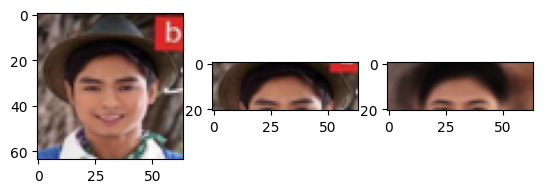

In [110]:
x = torch.from_numpy(train)
train_set = CustomTensorDataset(x)
img_idx = 2666
ori_img = train_set.__get_ori_item__(img_idx)
ori_img = ori_img.reshape(1,3,64,64) #2. * x/255. - 1.
ori_img = np.array(ori_img[0].permute(1,2,0))
ori_img = (ori_img + 1)/2*255

tfm_img = train_set[img_idx]
tfm_img = tfm_img.reshape(1,3,21,64) #2. * x/255. - 1.
tfm_img = np.array(tfm_img[0].permute(1,2,0))
tfm_img = (tfm_img + 1)/2*255

img = train_set[img_idx]
img = img.reshape(1,3,21,64)
img = torch.tensor(img).reshape(img.shape[0], -1).cuda()
model.eval()
with torch.no_grad():
    out_img = model(img)
out_img = out_img.reshape(1,3,21,64).cpu() #2. * x/255. - 1.
out_img = np.array(out_img[0].permute(1,2,0))
out_img = (out_img + 1)/2*255

f, axarr = plt.subplots(1, 3)
axarr[0].imshow(ori_img.astype(np.uint8))
axarr[1].imshow(tfm_img.astype(np.uint8))
axarr[2].imshow(out_img.astype(np.uint8))
# plt.show()

/tmp/ipykernel_2960728/1494020861.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img).reshape(img.shape[0], -1).cuda()


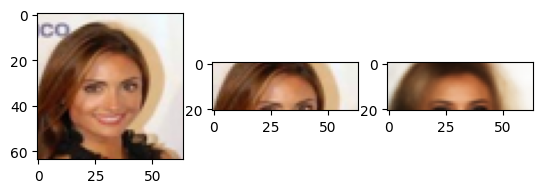

In [115]:
x = torch.from_numpy(train)
train_set = CustomTensorDataset(x)
img_idx = 13921
ori_img = train_set.__get_ori_item__(img_idx)
ori_img = ori_img.reshape(1,3,64,64) #2. * x/255. - 1.
ori_img = np.array(ori_img[0].permute(1,2,0))
ori_img = (ori_img + 1)/2*255

tfm_img = train_set[img_idx]
tfm_img = tfm_img.reshape(1,3,21,64) #2. * x/255. - 1.
tfm_img = np.array(tfm_img[0].permute(1,2,0))
tfm_img = (tfm_img + 1)/2*255

img = train_set[img_idx]
img = img.reshape(1,3,21,64)
img = torch.tensor(img).reshape(img.shape[0], -1).cuda()
model.eval()
with torch.no_grad():
    x = model.encoder(img)
    x[0][2] = x[0][2]*3
    output = model.decoder(x)
    out_img = model(output)
out_img = out_img.reshape(1,3,21,64).cpu() #2. * x/255. - 1.
out_img = np.array(out_img[0].permute(1,2,0))
out_img = (out_img + 1)/2*255

f, axarr = plt.subplots(1, 3)
axarr[0].imshow(ori_img.astype(np.uint8))
axarr[1].imshow(tfm_img.astype(np.uint8))
axarr[2].imshow(out_img.astype(np.uint8))
# plt.show()